In [1]:
import pandas as pd

data_summary = pd.read_csv("data_summary.csv")
data_summary.head()

,image_seq_path,image_seq_length,target,first_image,last_image
0,CK+/extended-cohn-kanade-images/cohn-kanade-im...,11,3.0,S005_001_00000001.png,S005_001_00000011.png
1,CK+/extended-cohn-kanade-images/cohn-kanade-im...,14,7.0,S010_002_00000001.png,S010_002_00000014.png
2,CK+/extended-cohn-kanade-images/cohn-kanade-im...,19,1.0,S010_004_00000001.png,S010_004_00000019.png
3,CK+/extended-cohn-kanade-images/cohn-kanade-im...,15,5.0,S010_006_00000001.png,S010_006_00000015.png
4,CK+/extended-cohn-kanade-images/cohn-kanade-im...,16,7.0,S011_001_00000001.png,S011_001_00000016.png


In [2]:
data_summary["target"].value_counts()

7.0    83
5.0    69
3.0    59
1.0    45
6.0    28
4.0    25
2.0    18
Name: target, dtype: int64

In [3]:
## Split the data into training and testing

In [4]:
## Since the data is class-imbalanced, sepearte out 7 samples from each class manually for testing(15% testing)
## The rest 85% of the samples will be preprocessd and class-balanced.
test_sample_size = 7 # per class
test_data = pd.DataFrame()
for i in range(1,8):
    sample = data_summary[data_summary["target"]==i].sample(test_sample_size, random_state=36)
    test_data = pd.concat([test_data, sample])

test_data.shape

(49, 5)

In [5]:
## Separate out the train data
train_data = data_summary[~data_summary.index.isin(test_data.index)]
train_data.shape

(278, 5)

In [6]:
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

## Save the splits
train_data.to_csv("train_data.csv",index=False)
test_data.to_csv("test_data.csv",index=False)

In [6]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

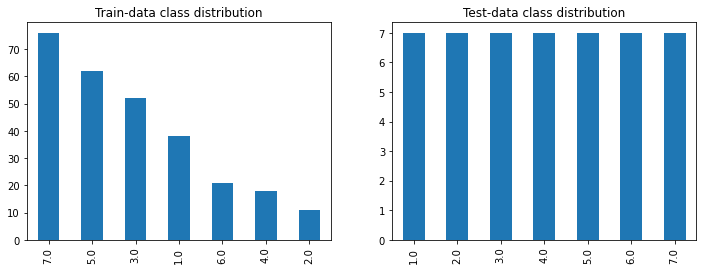

7.0    76
5.0    62
3.0    52
1.0    38
6.0    21
4.0    18
2.0    11
Name: target, dtype: int64

In [7]:
import matplotlib.pyplot as plt

## check the train and test data distributions
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train_data["target"].value_counts().plot(kind="bar")
plt.title("Train-data class distribution")
plt.subplot(1,2,2)
test_data["target"].value_counts().plot(kind="bar")
plt.title("Test-data class distribution")
plt.show()
train_data["target"].value_counts()

## Balancing Strategy

To balance the individual classes in the train data, a hybrid strategy is used which involves horizontal flipping, rotation..


    Class - Available/Required
        1 - 38/38 (13 + 13 + 12)
        2 - 11/65 (11 + 11 + 11) ---> (11 + 11) erosion and dilation are considered additionally.
        3 - 52/24 (8 + 8 + 8)
        4 - 18/58 (18 + 18 + 18) 
        5 - 62/14 (4 + 5 + 5)
        6 - 21/55 (18 + 18 + 19)
        7 - 76/0 

152


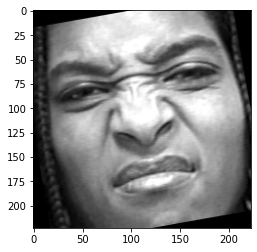

In [8]:
# plt.imshow(img)
# plt.show()
# plt.imshow(cv2.flip(img,3))
# plt.show()

import cv2
import os
import random

index = random.randint(0,277)
print (index)
img = cv2.imread(os.path.join("cropped_and_denoised", train_data["last_image"].iloc[index]))
height, width = img.shape[:2]
transf = cv2.getRotationMatrix2D((width/2, height/2),10,1)
rot_img = cv2.warpAffine(img, transf, (width, height))
plt.imshow(img)
plt.show
plt.imshow(rot_img)
plt.show()

In [9]:
## Balance out the train data class distribution using Data augmenation..
## class_samples --> {class: [#horizontal-flip, #10deg-rotation, #-10deg-rotation]}
## Samples are randomly selected

import shutil
import numpy as np

sample_lengths = {1: [13,13,14],
                2: [11,11,11],
                3: [8,8,8],
                4: [18,18,18],
                5: [4,5,5],
                6: [18,18,19],
                7: None}

train_aug = {"first_image":[],
            "target":[],
            "last_image":[]}
kernel = np.ones((3,3),np.uint8) # for class-2 (erosion and dilation)

for i in range(1,8):
    
    ## select the class data for test data and save it
    for _, row in test_data.iterrows():
        ## copy the data
        shutil.copy(os.path.join("cropped_and_denoised", row["first_image"]), 
                   os.path.join("test", row["first_image"]))
        shutil.copy(os.path.join("cropped_and_denoised", row["last_image"]), 
                   os.path.join("test", row["last_image"]))
    
    ## select the class data for train data
    class_train_data = train_data[train_data["target"]==i].copy()
    print ("Processing class ",i)
    
    ## copy all the samples(first and last images) to the "train" folder
    for _, row in class_train_data.iterrows():
        ## copy the data
        shutil.copy(os.path.join("cropped_and_denoised", row["first_image"]), 
                   os.path.join("train", row["first_image"]))
        shutil.copy(os.path.join("cropped_and_denoised", row["last_image"]), 
                   os.path.join("train", row["last_image"]))
        
        train_aug["first_image"].append(row["first_image"])
        train_aug["target"].append(i)
        train_aug["last_image"].append(row["last_image"])
        
    ## if it is class-7 (with the largest number of samples), skip augmentation
    if i == 7:
        continue
    else:
        ## randomly select images according to the set dictionary for horizontal flipping.
        samples = class_train_data.sample(sample_lengths[i][0])
        for _, row in samples.iterrows():
            ## load the neutral and peak images
            img1 = cv2.imread(os.path.join("train",row["first_image"]))
            img2 = cv2.imread(os.path.join("train",row["last_image"]))
            height1, width1 = img1.shape[:2]
            height2, width2 = img2.shape[:2]

            ## flip the neutral image horizontally
            flip_img1 = cv2.flip(img1, 3)
            filename = row["first_image"].replace(".png","") + "_hori.png"
            cv2.imwrite(os.path.join("train", filename), flip_img1)
            train_aug["first_image"].append(filename)
            train_aug["target"].append(i)

            ## flip the peak image horizontally
            flip_img2 = cv2.flip(img2, 3)
            filename = row["last_image"].replace(".png","") + "_hori.png"
            cv2.imwrite(os.path.join("train", filename), flip_img2)
            train_aug["last_image"].append(filename)
            
            ## Erode the neutral image
            ero_img1 = cv2.erode(img1, kernel, iterations=1)
            filename = row["first_image"].replace(".png","") + "_ero.png"
            cv2.imwrite(os.path.join("train", filename), ero_img1)
            train_aug["first_image"].append(filename)
            train_aug["target"].append(i)

            ## Erode the peak image
            ero_img2 = cv2.erode(img2, kernel, iterations=1)
            filename = row["last_image"].replace(".png","") + "_ero.png"
            cv2.imwrite(os.path.join("train", filename), ero_img2)
            train_aug["last_image"].append(filename)

            ## Dilate the neutral image
            dil_img1 = cv2.dilate(img1, kernel, iterations=1)
            filename = row["first_image"].replace(".png","") + "_dil.png"
            cv2.imwrite(os.path.join("train", filename), dil_img1)
            train_aug["first_image"].append(filename)
            train_aug["target"].append(i)

            ## Erode the peak image
            dil_img2 = cv2.erode(img2, kernel, iterations=1)
            filename = row["last_image"].replace(".png","") + "_dil.png"
            cv2.imwrite(os.path.join("train", filename), dil_img2)
            train_aug["last_image"].append(filename)
            
            ## in case of class:2, rotate +10 & -10 the images additionally
            if i == 2:
                ## rotate the neutral image by +10deg
                transf1 = cv2.getRotationMatrix2D((width1/2, height1/2),10,1)
                rot_img1 = cv2.warpAffine(img1, transf1, (width1, height1))
                filename = row["first_image"].replace(".png","") + "_+10rot.png"
                cv2.imwrite(os.path.join("train", filename), rot_img1)
                train_aug["first_image"].append(filename)
                train_aug["target"].append(i)

                ## rotate the peak image by +10deg
                transf2 = cv2.getRotationMatrix2D((width2/2, height2/2),10,1)
                rot_img2 = cv2.warpAffine(img2, transf2, (width2, height2))
                filename = row["last_image"].replace(".png","") + "_+10rot.png"
                cv2.imwrite(os.path.join("train", filename), rot_img2)
                train_aug["last_image"].append(filename)

                 ## rotate the neutral image by -10deg
                transf1 = cv2.getRotationMatrix2D((width1/2, height1/2),-10,1)
                rot_img1 = cv2.warpAffine(img1, transf1, (width1, height1))
                filename = row["first_image"].replace(".png","") + "_-10rot.png"
                cv2.imwrite(os.path.join("train", filename), rot_img1)
                train_aug["first_image"].append(filename)
                train_aug["target"].append(i)

                ## rotate the peak image by -10deg
                transf2 = cv2.getRotationMatrix2D((width2/2, height2/2),-10,1)
                rot_img2 = cv2.warpAffine(img2, transf2, (width2, height2))
                filename = row["last_image"].replace(".png","") + "_-10rot.png"
                cv2.imwrite(os.path.join("train", filename), rot_img2)
                train_aug["last_image"].append(filename)
                


Processing class  1
Processing class  2
Processing class  3
Processing class  4
Processing class  5
Processing class  6
Processing class  7


In [10]:
train_aug_df = pd.DataFrame(train_aug)
train_aug_df["target"].value_counts()

1    77
3    76
7    76
6    75
5    74
4    72
2    66
Name: target, dtype: int64

In [11]:
test_data["target"].value_counts()

1.0    7
2.0    7
3.0    7
4.0    7
5.0    7
6.0    7
7.0    7
Name: target, dtype: int64

In [12]:
train_aug_df.to_csv("train_aug.csv",index=False)

In [13]:
train_aug_df = pd.read_csv("train_aug.csv")

## Compute features

- Farenback optical flow
- Laplacian filter
- 

train\S097_004_00000001.png


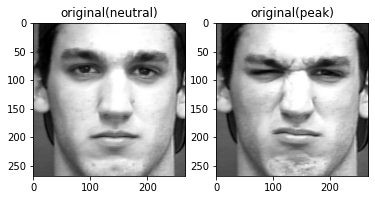

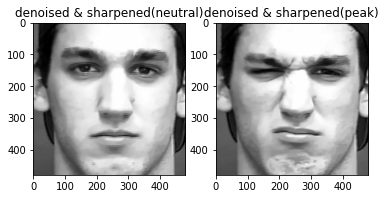

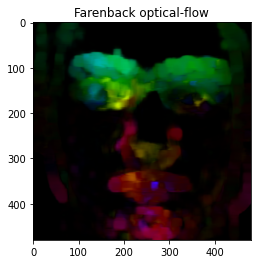

In [14]:
# generate farenback optical flow for the images
# Note: load data_summary before running this function

def return_farenback_of(img1, img2, output_path="", save=True, display=False):
    
    if display :
        plt.subplot(121);plt.imshow(img1);plt.title("original(neutral)")
        plt.subplot(122);plt.imshow(img2);plt.title("original(peak)")
        plt.show()
        
    img1 = cv2.resize(img1, (480, 480))
    img2 = cv2.resize(img2, (480, 480))
    
    ## denoise the image
    img1 = cv2.fastNlMeansDenoisingColored(img1)
    img2 = cv2.fastNlMeansDenoisingColored(img2)
    
    ## sharpen the image
    kernel3 = np.array([[0, -1,  0],
                       [-1,  5, -1],
                        [0, -1,  0]])
    img1 = cv2.filter2D(src=img1, ddepth=-1, kernel=kernel3)
    img2 = cv2.filter2D(src=img2, ddepth=-1, kernel=kernel3)
    
    if display :
        plt.subplot(121);plt.imshow(img1);plt.title("denoised & sharpened(neutral)")
        plt.subplot(122);plt.imshow(img2);plt.title("denoised & sharpened(peak)")
        plt.show()

    # Create mask
    hsv_mask = np.zeros_like(img1)
    
    # Make image saturation to a maximum value
    hsv_mask[..., 1] = 255

    # Convert 
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Calculate Optical Flow
    flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Compute magnite and angle of 2D vector
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Set image hue value according to the angle of optical flow
    hsv_mask[..., 0] = ang * 180 / np.pi / 2
    # Set value as per the normalized magnitude of optical flow
    hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to rgb
    bgr_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)
    
    if save:
        cv2.imwrite(output_path, bgr_representation)
    if display:
        plt.imshow(bgr_representation)
        plt.title("Farenback optical-flow")
        plt.show()
    return

index = 178#random.randint(0,500)
folder = "train"
print (os.path.join(folder,train_aug_df["first_image"].loc[index]))
img1 = cv2.imread(os.path.join(folder,train_aug_df["first_image"].loc[index]))
img2 = cv2.imread(os.path.join(folder,train_aug_df["last_image"].loc[index]))
output_path = "farenback_of" + "/" + "_".join(train_aug_df["first_image"].loc[index].split("_")[:2]) + ".png"
return_farenback_of(img1, img2, output_path, save=False, display=True)

In [15]:
input_folder = "train"
for index, row in train_aug_df.iterrows():
    print ("Processing sample: ",index+1)
    img1 = cv2.imread(os.path.join(input_folder,row["first_image"]))
    img2 = cv2.imread(os.path.join(input_folder,row["last_image"]))
    filename = row["first_image"].split("_")
    filename.pop(2)
    output_path = "train/farenback_of" + "/" + "_".join(filename).replace(".png","") + ".png"
    return_farenback_of(img1, img2, output_path=output_path, save=True, display=False)
    del img1, img2, output_path

Processing sample:  1
Processing sample:  2
Processing sample:  3
Processing sample:  4
Processing sample:  5
Processing sample:  6
Processing sample:  7
Processing sample:  8
Processing sample:  9
Processing sample:  10
Processing sample:  11
Processing sample:  12
Processing sample:  13
Processing sample:  14
Processing sample:  15
Processing sample:  16
Processing sample:  17
Processing sample:  18
Processing sample:  19
Processing sample:  20
Processing sample:  21
Processing sample:  22
Processing sample:  23
Processing sample:  24
Processing sample:  25
Processing sample:  26
Processing sample:  27
Processing sample:  28
Processing sample:  29
Processing sample:  30
Processing sample:  31
Processing sample:  32
Processing sample:  33
Processing sample:  34
Processing sample:  35
Processing sample:  36
Processing sample:  37
Processing sample:  38
Processing sample:  39
Processing sample:  40
Processing sample:  41
Processing sample:  42
Processing sample:  43
Processing sample:  

Processing sample:  347
Processing sample:  348
Processing sample:  349
Processing sample:  350
Processing sample:  351
Processing sample:  352
Processing sample:  353
Processing sample:  354
Processing sample:  355
Processing sample:  356
Processing sample:  357
Processing sample:  358
Processing sample:  359
Processing sample:  360
Processing sample:  361
Processing sample:  362
Processing sample:  363
Processing sample:  364
Processing sample:  365
Processing sample:  366
Processing sample:  367
Processing sample:  368
Processing sample:  369
Processing sample:  370
Processing sample:  371
Processing sample:  372
Processing sample:  373
Processing sample:  374
Processing sample:  375
Processing sample:  376
Processing sample:  377
Processing sample:  378
Processing sample:  379
Processing sample:  380
Processing sample:  381
Processing sample:  382
Processing sample:  383
Processing sample:  384
Processing sample:  385
Processing sample:  386
Processing sample:  387
Processing sampl

S114_001, S111_001, S085_003, S080_001, S064_001, S062_002, S058_001, S044_001, S037_001, S034_001, S080_005_dil,
S138_007_ero, S081_002_dil, S081_002_hori, S046_001_ero, S130_009_hori, S064_004_dil, S138_007, S130_009, S081_002,
S046_001, S074_005_dil, S074_005_hori, S128_011_dil, S128_011_hori, S128_011, S124_007, S098_004, S085_002, S063_002,
S035_006, S068_004_dil, S055_006_dil, S055_006_hori, S124_003_hori, S084_002_ero, S124_003, S084_002, S062_005_ero,
S128_004_dil, S078_007_ero, S061_004_ero, S131_010, S082_007, S075_005, S005_001, S504_002_-10rot, S504_002_dil,
S504_002_ero, S504_002_hori, S895_002_+10rot, S139_002_-10rot, S504_002, S092_003

In [16]:
glitches= '''S114_001, S111_001, S085_003, S080_001, S064_001, S062_002, S058_001, S044_001, S037_001, S034_001, S080_005_dil,
S138_007_ero, S081_002_dil, S081_002_hori, S046_001_ero, S130_009_hori, S064_004_dil, S138_007, S130_009, S081_002,
S046_001, S074_005_dil, S074_005_hori, S128_011_dil, S128_011_hori, S128_011, S124_007, S098_004, S085_002, S063_002,
S035_006, S068_004_dil, S055_006_dil, S055_006_hori, S124_003_hori, S084_002_ero, S124_003, S084_002, S062_005_ero,
S128_004_dil, S078_007_ero, S061_004_ero, S131_010, S082_007, S075_005, S005_001, S504_002_-10rot, S504_002_dil,
S504_002_ero, S504_002_hori, S895_002_+10rot, S139_002_-10rot, S504_002, S092_003'''

glitches = glitches.replace("\n","").replace(" ","").split(",")
indices = []
for filename in glitches:
    suffix = filename.split("_")[-1]
    if suffix in ["+10rot", "-10rot", "hori", "ero", "dil"]:
        indices.extend(train_aug_df[(train_aug_df["first_image"].str[:8]==filename[:8])&
                                  (train_aug_df["first_image"].str.contains(suffix, regex=False))].index.values)
    else :
        indices.extend(train_aug_df[(train_aug_df["first_image"].str[:8]==filename)&
                            (~train_aug_df["first_image"].str.contains("_[\+\-hed]"))].index.values)

print (indices)
assert len(indices) == len(glitches)

[499, 497, 483, 479, 465, 463, 459, 449, 447, 445, 439, 429, 421, 419, 396, 392, 388, 383, 379, 373, 369, 364, 362, 358, 356, 344, 342, 334, 323, 307, 296, 278, 260, 258, 255, 244, 231, 227, 214, 206, 202, 196, 192, 171, 165, 143, 127, 125, 124, 123, 96, 92, 86, 20]


train\S114_001_00000001.png
train/farenback_of/S114_001.png


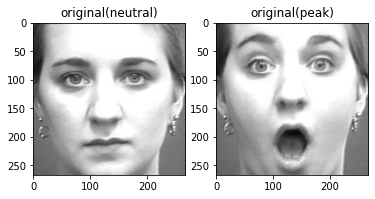

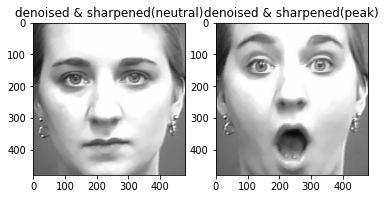

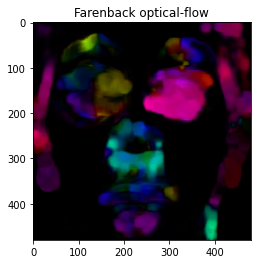

In [146]:
# manually run again for all-zero cases (not sure why but sometimes the result gets all zeroes for the same input)
index = 499
folder = "train"
print (os.path.join(folder,train_aug_df["first_image"].loc[index]))
img1 = cv2.imread(os.path.join(folder,train_aug_df["first_image"].loc[index]))
img2 = cv2.imread(os.path.join(folder,train_aug_df["last_image"].loc[index]))
filename = train_aug_df["first_image"].loc[index].split("_")
filename.pop(2)
output_path = "train/farenback_of" + "/" + "_".join(filename).replace(".png","") + ".png"
print (output_path)
return_farenback_of(img1, img2, output_path, save=True, display=True)

## Generate features for the test data

In [147]:
input_folder = "test"
for index, row in test_data.iterrows():
    print ("Processing sample: ",index+1)
    img1 = cv2.imread(os.path.join(input_folder,row["first_image"]))
    img2 = cv2.imread(os.path.join(input_folder,row["last_image"]))
    filename = row["first_image"].split("_")
    filename.pop(2)
    output_path = "test/farenback_of" + "/" + "_".join(filename).replace(".png","") + ".png"
    return_farenback_of(img1, img2, output_path=output_path, save=True, display=False)
    del img1, img2, output_path

Processing sample:  1
Processing sample:  2
Processing sample:  3
Processing sample:  4
Processing sample:  5
Processing sample:  6
Processing sample:  7
Processing sample:  8
Processing sample:  9
Processing sample:  10
Processing sample:  11
Processing sample:  12
Processing sample:  13
Processing sample:  14
Processing sample:  15
Processing sample:  16
Processing sample:  17
Processing sample:  18
Processing sample:  19
Processing sample:  20
Processing sample:  21
Processing sample:  22
Processing sample:  23
Processing sample:  24
Processing sample:  25
Processing sample:  26
Processing sample:  27
Processing sample:  28
Processing sample:  29
Processing sample:  30
Processing sample:  31
Processing sample:  32
Processing sample:  33
Processing sample:  34
Processing sample:  35
Processing sample:  36
Processing sample:  37
Processing sample:  38
Processing sample:  39
Processing sample:  40
Processing sample:  41
Processing sample:  42
Processing sample:  43
Processing sample:  

test\S504_004_00000001.png


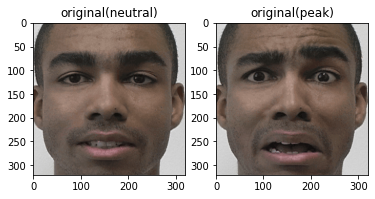

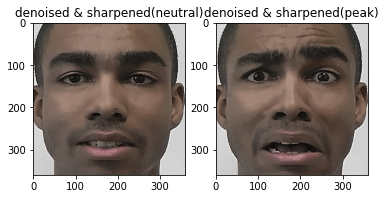

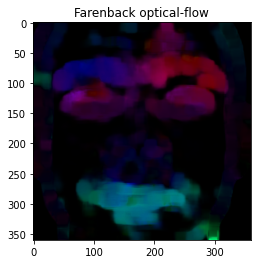

In [40]:
# manually run again for all-zero cases (not sure why but sometimes the result gets all zeroes for the same input)
# for images: S014_003, S062_001, S089_001, S504_004
# for indices: 5, 27, 42, 26
# test_data[test_data["first_image"].str[:8]=="S504_004"]

index = 26
folder = "test"
print (os.path.join(folder,test_data["first_image"].loc[index]))
img1 = cv2.imread(os.path.join(folder,test_data["first_image"].loc[index]))
img2 = cv2.imread(os.path.join(folder,test_data["last_image"].loc[index]))
output_path = "test/farenback_of" + "/" + "_".join(test_data["first_image"].loc[index].split("_")[:2]) + ".png"
return_farenback_of(img1, img2, output_path, save=True, display=True)